In [2]:
import phate
import scprep
import seaborn as sns
import os
import json
from PIL import Image, ImageDraw
import re
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
import tifffile as tiff
from tqdm import tqdm
from skimage.exposure import equalize_adapthist
from scipy.stats import stats
import matplotlib.animation as animation
import pandas as pd
import csv
import shutil
from skimage.morphology import dilation, erosion
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage import measure
from skimage.measure import regionprops, label
from scipy.spatial import distance
import time
import datetime
from mpl_toolkits.mplot3d import Axes3D  # 3D Plotting
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns
from scipy.ndimage import center_of_mass
from glob import glob
import random
import imageio.v2 as imageio
from tifffile import imread


# Centroid calculation by Median instead of Mean

In [3]:

def analyze_cells_by_mask_labels_with_velocity_corrected(mask_directory, output_directory, size_threshold=1000):
    """Corrected: Extract shape features and centroid velocities per cell per frame using true mask label values (not region.label)."""

    def median_centroid(region):
        coords = region.coords  # shape (N, 2): rows (y), cols (x)
        y_median = np.median(coords[:, 0])
        x_median = np.median(coords[:, 1])
        return x_median, y_median  # return in (x, y) order for consistency

    def calculate_shape_factors(region):
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        cx, cy = median_centroid(region)
        cx *= 0.68
        cy *= 0.68

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}.")

    all_results = []

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]

        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            coords = region.coords
            actual_labels = np.unique(mask[coords[:, 0], coords[:, 1]])
            actual_labels = [val for val in actual_labels if val != 0]
            if not actual_labels:
                continue
            cell_id = actual_labels[0]  # Real label from mask, not from relabeling
            all_results.append([cell_id, frame] + shape_factors)

    df = pd.DataFrame(all_results, columns=[
        "Cell_ID", "Frame", "Area", "Perimeter", "Solidity", "Extent",
        "Circularity", "Convexity", "Elongation", "Compactness", "Centroid_X", "Centroid_Y"
    ])

    df.sort_values(by=["Cell_ID", "Frame"], inplace=True)

    df["X_Centroid_Distance"] = df.groupby("Cell_ID")["Centroid_X"].diff().fillna(0)
    df["Y_Centroid_Distance"] = df.groupby("Cell_ID")["Centroid_Y"].diff().fillna(0)
    df["Frame_Diff"] = df.groupby("Cell_ID")["Frame"].diff().fillna(1)
    df["X_Centroid_Velocity"] = df["X_Centroid_Distance"] / df["Frame_Diff"]
    df["Y_Centroid_Velocity"] = df["Y_Centroid_Distance"] / df["Frame_Diff"]
    df.drop(columns="Frame_Diff", inplace=True)

    os.makedirs(output_directory, exist_ok=True)
    
    corrected_csv_path = os.path.join(output_directory, f"Cells_Shape_Features_TrueLabels_With_Velocity.csv")

    df.to_csv(corrected_csv_path, index=False)
    df.replace([np.inf, -np.inf], 0, inplace=True)

    return df, corrected_csv_path

print("✔ Corrected version: Now using **median-based** centroids instead of mean.")



#######  Example usage
mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"
output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Shape_Measure-Median"

results_df, csv_path = analyze_cells_by_mask_labels_with_velocity_corrected(mask_directory, output_directory)

# Display the first few rows of the resulting DataFrame
print(results_df.head(10))
print(f"CSV saved at: {csv_path}")



✔ Corrected version: Now using **median-based** centroids instead of mean.
     Cell_ID  Frame     Area    Perimeter  Solidity    Extent  Circularity  \
0          1      0  19791.0  1305.303607  0.745677  0.512826     0.145967   
1          2      0  20178.0   740.918831  0.827374  0.622240     0.461899   
13         2      1  20663.0   694.090404  0.849385  0.620678     0.538978   
26         2      2  19913.0   695.019336  0.831788  0.642853     0.518027   
39         2      3  18146.0   750.818326  0.806023  0.605432     0.404502   
52         2      4  20733.0   885.144228  0.790009  0.620823     0.332540   
65         2      5  17514.0   668.776695  0.863950  0.647995     0.492077   
78         2      6  19168.0   725.303607  0.834770  0.614359     0.457875   
89         2      7  19780.0   758.859956  0.806228  0.601801     0.431631   
101        2      8  20539.0   744.960461  0.815881  0.608960     0.465075   

     Convexity  Elongation  Compactness  Centroid_X  Centroid_Y  \

# Centroid calculation by Median instead of Mean
# Moving Average of Shape Features
# Cell ID matching with Tracking Masks

✔ Corrected version: Now using **median-based** centroids instead of mean. Moving Average of shapr Features


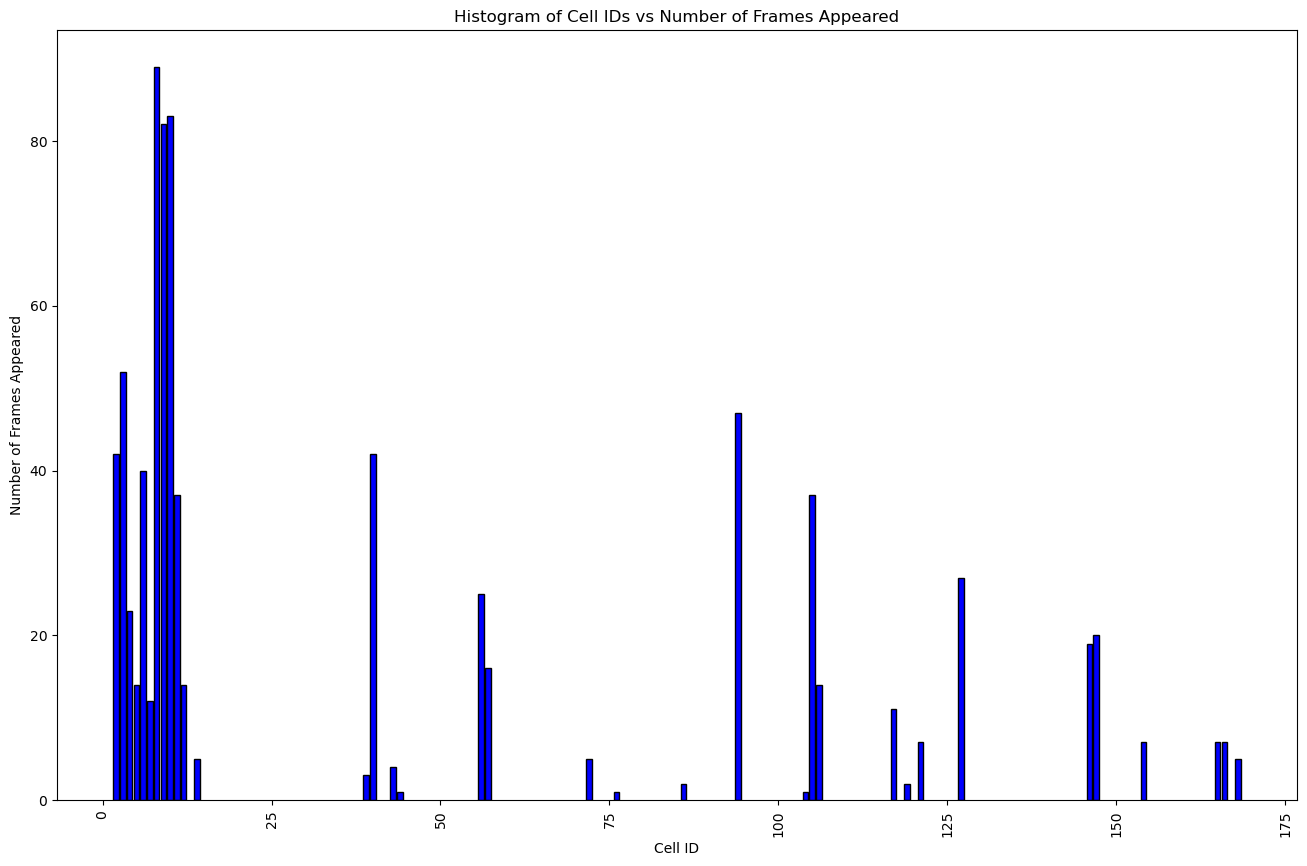

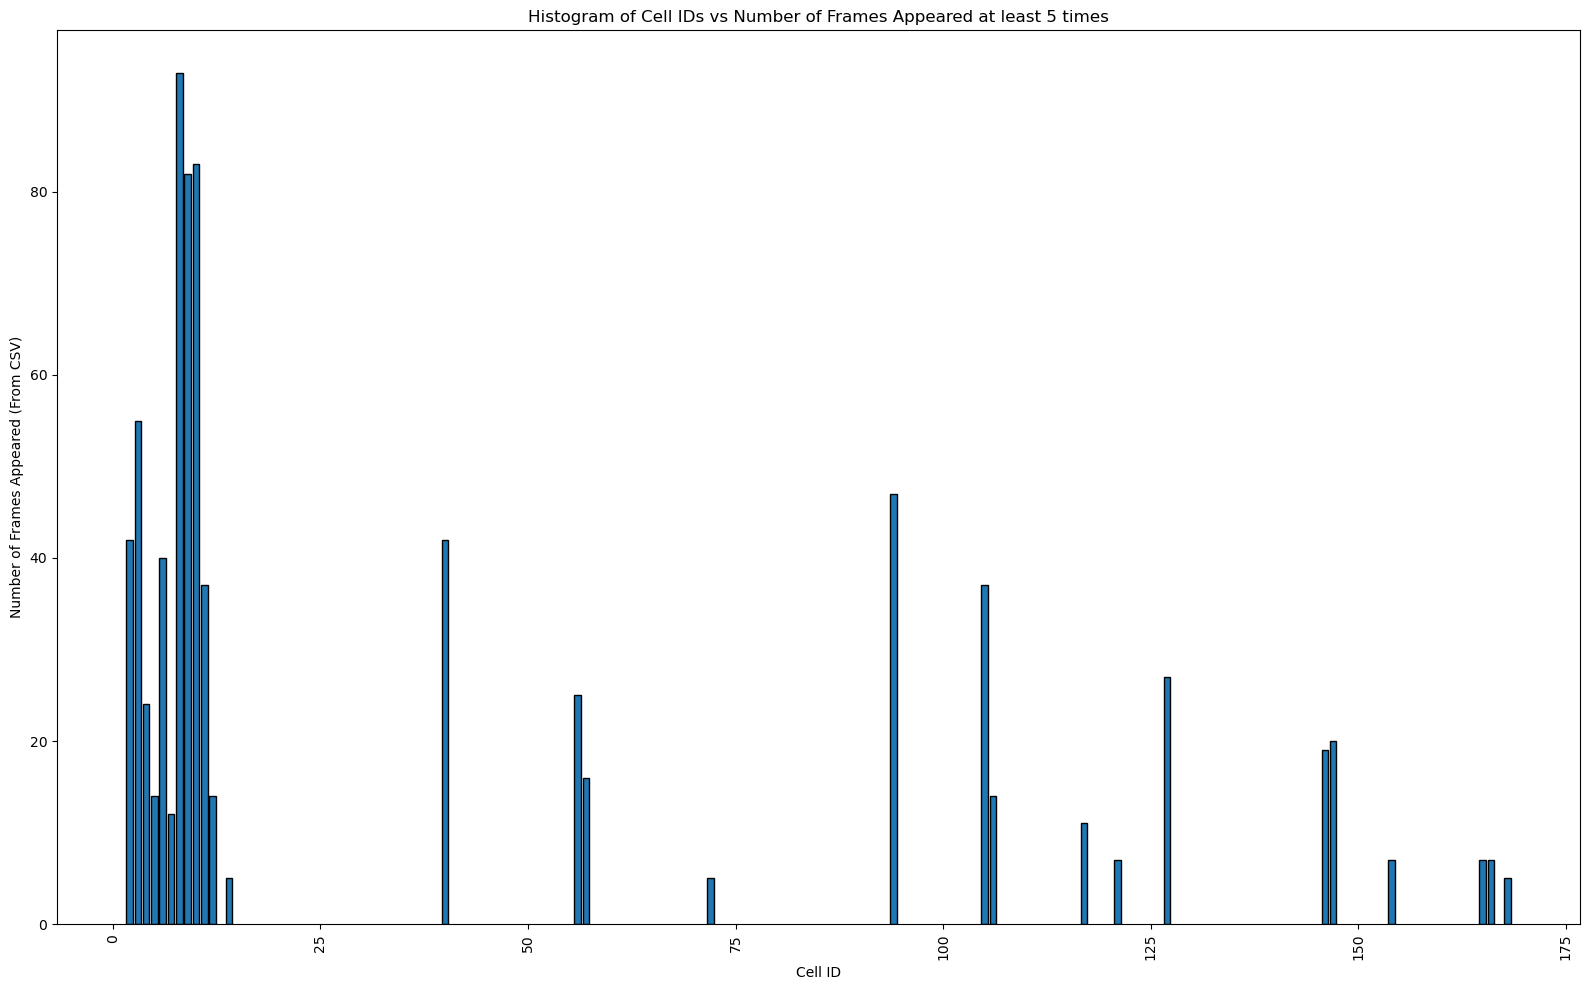

    Cell Number                                    Frames Appeared
0             2  [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 1...
1             3  [1, 2, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15...
2             4  [1, 2, 3, 4, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...
3             5   [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
4             6  [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 1...
5             7           [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 14, 15]
6             8  [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 15, 1...
7             9  [1, 2, 3, 4, 5, 6, 7, 9, 10, 13, 14, 16, 17, 1...
8            10  [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...
9            11  [1, 2, 3, 4, 8, 9, 10, 11, 12, 14, 16, 17, 18,...
10           12   [1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16]
11           14                                    [2, 3, 4, 5, 6]
12           40  [18, 19, 20, 21, 24, 26, 27, 28, 30, 32, 33, 3...
13           56  [27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 

In [ ]:


def analyze_cells_by_mask_labels_with_velocity_corrected(mask_directory, output_directory, size_threshold=1000, window_size=5):
    """Corrected & Enhanced: Extracts true-label shape features, centroid velocities, moving averages, and visualizations."""

    start_time = time.time()

    def median_centroid(region):
        coords = region.coords
        y_median = np.median(coords[:, 0])
        x_median = np.median(coords[:, 1])
        return x_median, y_median

    def calculate_shape_factors(region):
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        cx, cy = median_centroid(region)
        cx *= 0.68
        cy *= 0.68

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}.")

    all_results = []

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        if mask is None:
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]

        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            coords = region.coords
            actual_labels = np.unique(mask[coords[:, 0], coords[:, 1]])
            actual_labels = [val for val in actual_labels if val != 0]
            if not actual_labels:
                continue
            cell_id = actual_labels[0]
            all_results.append([cell_id, frame] + shape_factors)

    df = pd.DataFrame(all_results, columns=[
        "Cell Number", "Frame", "Area", "Perimeter", "Solidity", "Extent",
        "Circularity", "Convexity", "Elongation", "Compactness", "Centroid_X", "Centroid_Y"
    ])

    df.sort_values(by=["Cell Number", "Frame"], inplace=True)

    # Calculate velocities
    df["X_Centroid_Distance"] = df.groupby("Cell Number")["Centroid_X"].diff().fillna(0)
    df["Y_Centroid_Distance"] = df.groupby("Cell Number")["Centroid_Y"].diff().fillna(0)
    df["Frame_Diff"] = df.groupby("Cell Number")["Frame"].diff().fillna(1)
    df["X_Centroid_Velocity"] = df["X_Centroid_Distance"] / df["Frame_Diff"]
    df["Y_Centroid_Velocity"] = df["Y_Centroid_Distance"] / df["Frame_Diff"]
    df.drop(columns="Frame_Diff", inplace=True)

    # Remove velocity=0 rows
    df = df[(df["X_Centroid_Velocity"] != 0) & (df["Y_Centroid_Velocity"] != 0)]

    # Filter cells with at least 5 frames
    frame_counts = df.groupby("Cell Number")["Frame"].nunique()
    valid_cells = frame_counts[frame_counts >= 5].index
    df = df[df["Cell Number"].isin(valid_cells)].sort_values(by=["Cell Number", "Frame"])

    # Frame list generation
    frame_list = df.groupby("Cell Number")["Frame"].apply(list).reset_index()
    frame_list.columns = ["Cell Number", "Frames Appeared"]

    os.makedirs(output_directory, exist_ok=True)

    # Save original CSV
    original_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_Original_TrueLabel_Median_{window_size}.csv")
    df.to_csv(original_csv_path, index=False)

    # Save frame list
    frame_list.to_csv(os.path.join(output_directory, f"Cells_Frames_List_HP4_Sign_TrueLabel_Median_{window_size}.csv"), index=False)

    # Moving average computation
    moving_average_variables = [
        "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation",
        "Circularity", "Convexity", "Centroid_X", "Centroid_Y",
        "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"
    ]

    for var in moving_average_variables:
        df[f"{var}_MA"] = df.groupby("Cell Number")[var].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

    # Save MA CSV
    ma_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_TrueLabel_MA_Median_{window_size}.csv")
    df.to_csv(ma_csv_path, index=False)

    # Histogram plot
    plt.figure(figsize=(16, 10))
    plt.bar(frame_counts.index, frame_counts.values, color='blue', edgecolor='black')
    plt.xlabel("Cell ID")
    plt.ylabel("Number of Frames Appeared")
    plt.title("Histogram of Cell IDs vs Number of Frames Appeared")
    plt.xticks(rotation=90)
    plt.savefig(os.path.join(output_directory, f"Cell_IDs_vs_Frames_Distribution_Cell_WTZV.png"))
    plt.show()

    # Additional Bar Plot from frame_list CSV
    frame_list_csv_path = os.path.join(output_directory, f"Cells_Frames_List_HP4_Sign_TrueLabel_Median_{window_size}.csv")
    if os.path.exists(frame_list_csv_path):
        frame_list_df = pd.read_csv(frame_list_csv_path)
        frame_list_df["Frames Count"] = frame_list_df["Frames Appeared"].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

        plt.figure(figsize=(16, 10))
        plt.bar(frame_list_df["Cell Number"], frame_list_df["Frames Count"], edgecolor='black')
        plt.xlabel("Cell ID")
        plt.ylabel("Number of Frames Appeared (From CSV)")
        plt.title(f"Histogram of Cell IDs vs Number of Frames Appeared at least {window_size} times")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.savefig(os.path.join(output_directory, f"Cell_IDs_vs_Frames_0{window_size}.png"))
        plt.show()
    else:
        print(f"Warning: {frame_list_csv_path} not found. Skipping additional bar plot.")

    print(frame_list)
    print(f"Original results saved at: {original_csv_path}")
    print(f"Results with moving averages saved at: {ma_csv_path}")
    print(f"Execution Time: {time.time() - start_time:.2f} seconds")

    return df

print("✔ Corrected version: Now using **median-based** centroids instead of mean. Moving Average of shapr Features")

mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"
output_directory = "/home/MinaHossain/EmbedTrack/Cell_Frame-Video/Shape_Measure-Median"

results_df = analyze_cells_by_mask_labels_with_velocity_corrected(mask_directory, output_directory)
print(results_df.head(15))



